# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Libraries

In [3]:
# Data
import ast
import pandas as pd
import numpy as np
from typing import Dict
# ML
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Functions

### Data Analysis

In [4]:
def explore_qualitative_variables(df, variables):
    for var in variables:
        if var not in df.columns:
            print(f"Variable '{var}' not found in DataFrame columns.")
            continue

        # Calculate frequency count
        freq_count = df[var].value_counts()

        # Calculate participation rate
        participation = freq_count / len(df) * 100

        # Prepare DataFrame for plotting
        summary_df = pd.DataFrame({
            'Frequency': freq_count,
            'Participation (%)': participation
        }).reset_index().rename(columns={'index': var})

        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Plot frequency as bars on the left y-axis
        sns.barplot(x=var, y='Frequency', data=summary_df, ax=ax1, color='blue', alpha=0.6, label='Frequency')
        ax1.set_ylabel('Frequency', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Create a second y-axis for participation
        ax2 = ax1.twinx()
        sns.lineplot(x=var, y='Participation (%)', data=summary_df, ax=ax2, color='orange', marker='o', label='Participation (%)')
        ax2.set_ylabel('Participation (%)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Frequency and Participation of {var}')
        plt.xlabel(var)

        # Set correct x-ticks and x-tick labels
        ax1.set_xticks(range(len(summary_df[var])))  # Ensure tick positions correspond to categories
        ax1.set_xticklabels(summary_df[var], rotation=45)  # Set the tick labels

        plt.show()


def explore_quantitive_variables(data, variables):

    df = data[variables]

    # Do a summary statistics
    summary_statistics = df.describe()
    print(summary_statistics)

    # Create a pairplot for scatter plots and histograms
    sns.pairplot(df)
    plt.suptitle('Pair Plot of Values', y=1.02)  # Title above the plot
    plt.show()

    # Estimate Correlations
    correlation_matrix = df.corr()

    # Plot the heatmap of the correlation coefficient matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title('Correlation Coefficient Matrix')
    plt.show()


def check_unique_combinations(df, fields):
    if not fields:
        raise ValueError("The list of fields cannot be empty.")
    unique_counts = df.groupby(fields).size()
    is_unique = all(unique_counts == 1)
    return is_unique


def find_duplicate_ids(df, fields):
    if not fields:
        raise ValueError("The list of fields cannot be empty.")
    duplicates = df[df.duplicated(subset=fields, keep=False)]
    return duplicates

### Preprocessing

In [5]:
def convert_list_to_string(df, column_name):
    new_column_name = f'concatenated_{column_name}'
    df[new_column_name] = df[column_name].apply(lambda x: '+'.join(map(str, x)))
    return df

### Feature Engineering

In [6]:
def max_scaling(df, field_name):
    new_column_name = f'max_scaling_{field_name}'
    max_value = df[field_name].max()
    df[new_column_name] = df[field_name] / max_value
    return df


def min_scaling(df, field_name):
    new_column_name = f'min_scaling_{field_name}'
    min_value = df[field_name][df[field_name] != 0].min()
    df[new_column_name] = np.where(df[field_name] == 0, 0, min_value / df[field_name])
    df[new_column_name] = df[new_column_name].fillna(0)
    return df


def score_portfolio(portfolio_df):

    portfolio_df = max_scaling(portfolio_df, "reward")
    portfolio_df = min_scaling(portfolio_df, "difficulty")
    portfolio_df = max_scaling(portfolio_df, "duration")

    portfolio_df["score"] = (
        portfolio_df["max_scaling_reward"]*0.4
        + portfolio_df["max_scaling_duration"]*0.2
        + portfolio_df["min_scaling_difficulty"]*0.4
    )*100

    return portfolio_df


def generate_profile_kmeans_clusters(df, n_clusters=3, random_state=42, plot=True):
    # Select relevant features
    numerical_features = ['age', 'income']
    categorical_features = ['gender']

    # Create a copy of the input dataframe
    X = df.copy()

    # One-hot encode the gender column
    gender_encoded = pd.get_dummies(X['gender'], prefix='gender', dummy_na=True)

    # Combine numerical features and encoded gender
    X_combined = pd.concat([X[numerical_features], gender_encoded], axis=1)

    # Create a pipeline that includes imputation and scaling
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Preprocess the data
    X_preprocessed = preprocessor.fit_transform(X_combined)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_preprocessed)

    # Add cluster labels to the original dataframe
    df_with_clusters = df.copy()
    df_with_clusters['customer_type'] = cluster_labels

    if plot:
        # Visualize clusters (using first three features)
        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], X_preprocessed[:, 2],
                             c=cluster_labels, cmap='viridis')
        ax.set_xlabel('Age (scaled)')
        ax.set_ylabel('Income (scaled)')
        ax.set_zlabel('Years since joining (scaled)')
        plt.title('3D visualization of clusters')
        plt.colorbar(scatter)
        plt.show()

        # Elbow method
        inertias = []
        range_n_clusters = range(1, 11)
        for n in range_n_clusters:
            kmeans = KMeans(n_clusters=n, random_state=random_state)
            kmeans.fit(X_preprocessed)
            inertias.append(kmeans.inertia_)

        plt.figure(figsize=(10, 6))
        plt.plot(range_n_clusters, inertias, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()

    return df_with_clusters


def replace_with_quintile_labels(df):
    # Create a copy to avoid modifying the original DataFrame
    df_quintiles = df.copy()

    # Iterate over each numerical column in the DataFrame
    for column in df_quintiles.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate the quintiles
        Q1 = df_quintiles[column].quantile(0.20)
        Q2 = df_quintiles[column].quantile(0.40)
        Q3 = df_quintiles[column].quantile(0.60)
        Q4 = df_quintiles[column].quantile(0.80)

        # Replace the values with quintile labels
        df_quintiles[column] = pd.cut(df_quintiles[column],
                                       bins=[-float('inf'), Q1, Q2, Q3, Q4, float('inf')],
                                       labels=['E', 'D', 'C', 'B', 'A'],
                                       right=False)  # right=False means left-closed intervals

    return df_quintiles

### Modelling

In [7]:
def generate_model_kmeans_clusters(df, n_clusters=3, random_state=42, plot=True):
    # Select relevant features
    categorical_features = ['customer_type']
    numerical_features = list(set(df.columns) - set(categorical_features) - set(["profile_id"]))

    # Create a copy of the input dataframe
    X = df.copy()

    # One-hot encode the customer_type column
    encoder = OneHotEncoder(sparse_output=False)
    customer_type_encoded = encoder.fit_transform(X[categorical_features])

    # Create a DataFrame with correct column names
    customer_type_encoded_df = pd.DataFrame(customer_type_encoded, columns=encoder.get_feature_names_out(['customer_type']))

    # Combine numerical features and encoded customer types
    X_combined = pd.concat([X[numerical_features], customer_type_encoded_df], axis=1)

    # Create a pipeline that includes imputation and scaling
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Preprocess the data
    X_preprocessed = preprocessor.fit_transform(X_combined)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_preprocessed)

    # Add cluster labels to the original dataframe
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels

    if plot:
        # Elbow method
        inertias = []
        range_n_clusters = range(1, 11)
        for n in range_n_clusters:
            kmeans = KMeans(n_clusters=n, random_state=random_state)
            kmeans.fit(X_preprocessed)
            inertias.append(kmeans.inertia_)

        plt.figure(figsize=(10, 6))
        plt.plot(range_n_clusters, inertias, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()

    return df_with_clusters

## Load the Data

In [10]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [11]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
print(f"Number of rows: {len(portfolio)}")

Number of rows: 10


In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
print(f"Number of rows: {len(profile)}")

Number of rows: 17000


In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
print(f"Number of rows: {len(transcript)}")

Number of rows: 306534


## Exploration Data Analysis

### Portfolio

#### Qualitative Analysis

In [17]:
new_portfolio = convert_list_to_string(portfolio, "channels")

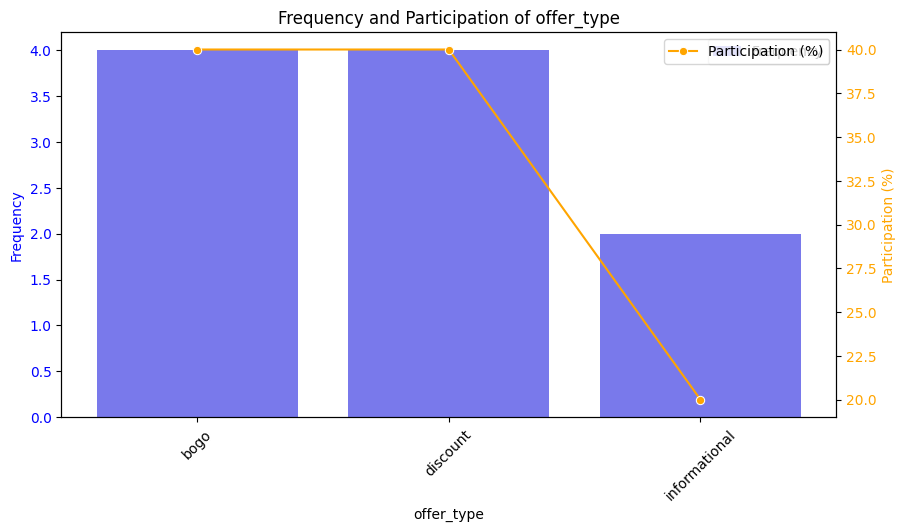

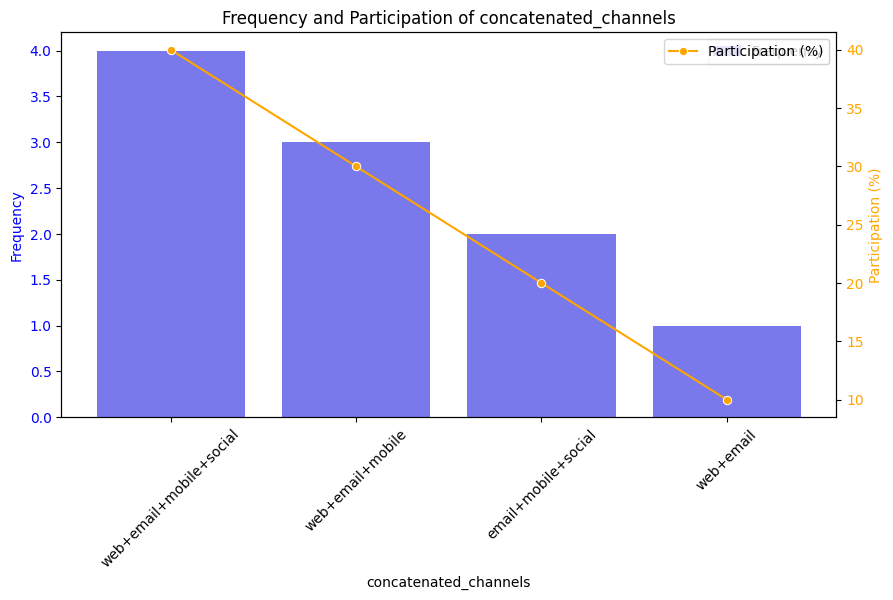

In [18]:
explore_qualitative_variables(new_portfolio, ["offer_type","concatenated_channels"])

#### Quantitative Analysis

       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000


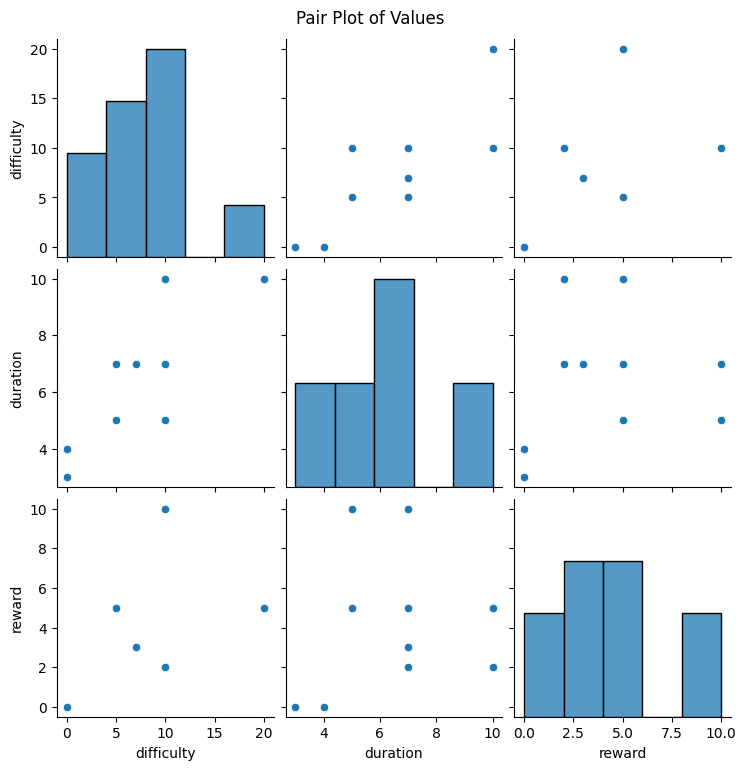

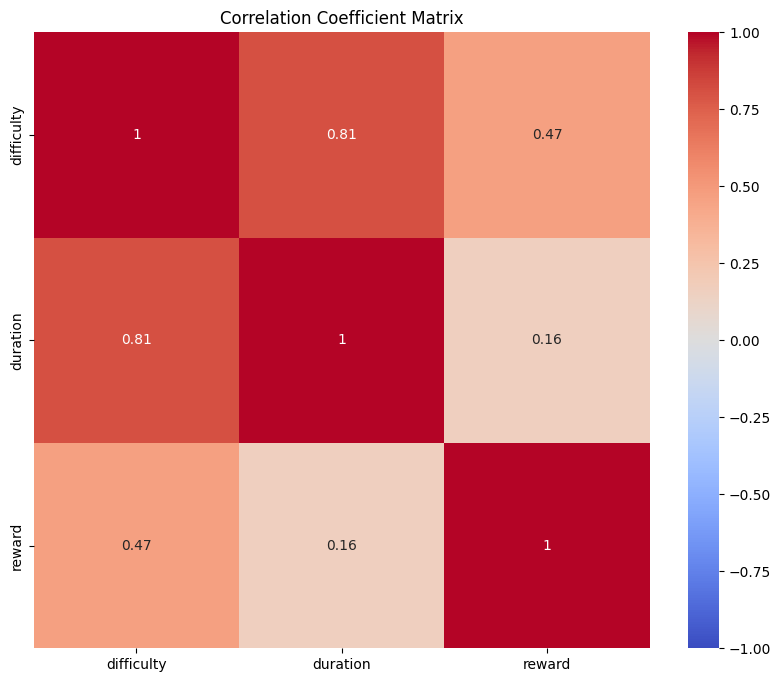

In [19]:
explore_quantitive_variables(portfolio, ["difficulty","duration","reward"])

### Profile

#### Qualitative Analysis

In [20]:
grouped_size = profile.groupby('gender').size().reset_index(name='Count')
print(grouped_size)

  gender  Count
0      F   6129
1      M   8484
2      O    212


In [21]:
new_profile = profile
new_profile["gender"] = new_profile["gender"].replace(0,"NA")

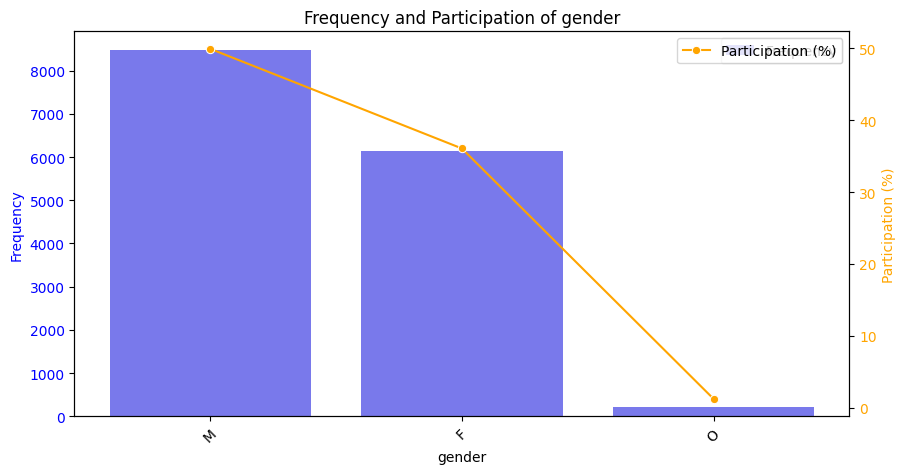

In [22]:
explore_qualitative_variables(new_profile, ["gender"])

#### Quantitative Analysis

                age         income
count  17000.000000   17000.000000
mean      62.531412   57037.000000
std       26.738580   29734.044501
min       18.000000       0.000000
25%       45.000000   40000.000000
50%       58.000000   59000.000000
75%       73.000000   76000.000000
max      118.000000  120000.000000


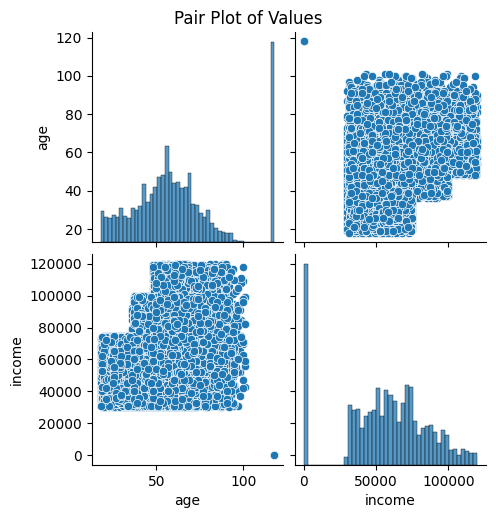

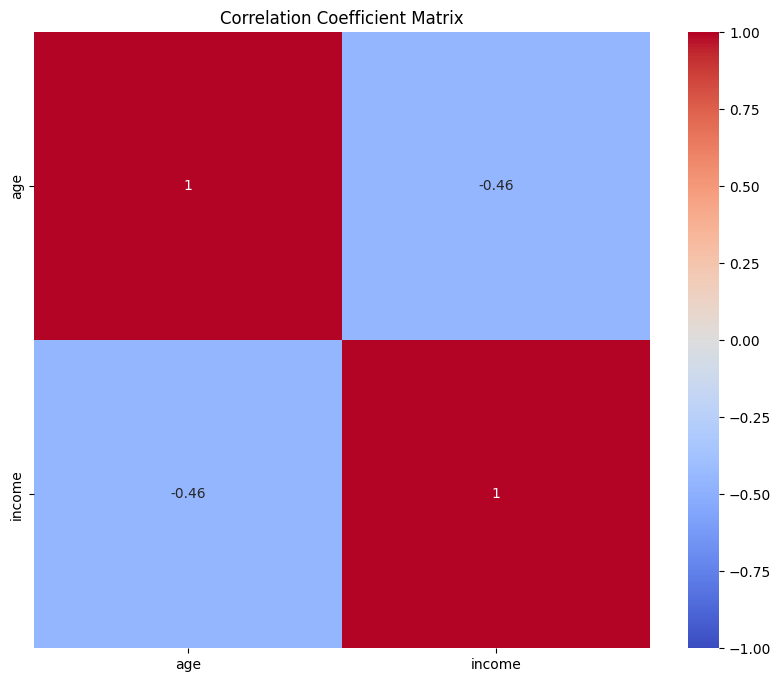

In [23]:
explore_quantitive_variables(profile.fillna(0), ["age","income"])

### Transcript

#### Qualitative Analysis

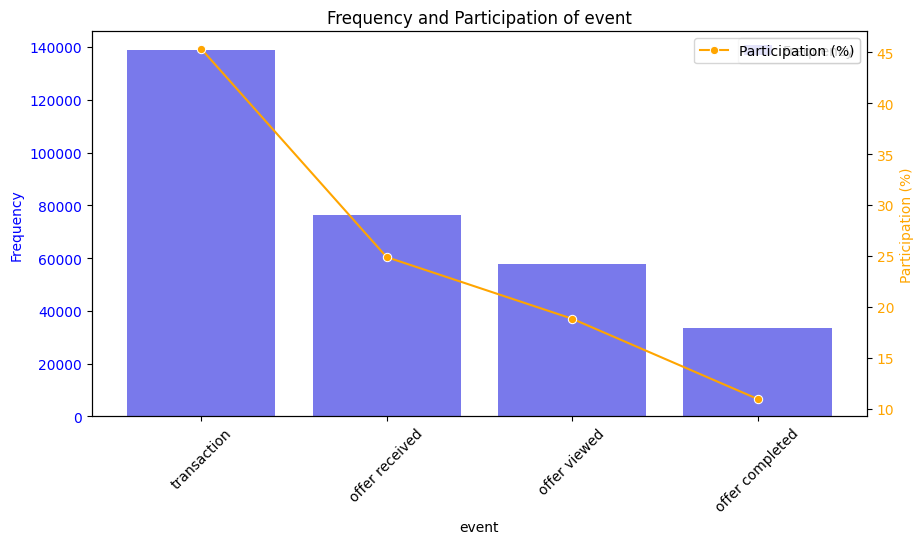

In [24]:
explore_qualitative_variables(transcript, ["event"])

#### Quantitative Analysis

In [25]:
transcript.fillna(0).describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [26]:
result_df = transcript.groupby(["event","person"])['value'].count().reset_index()
result_df.head()

,event,person,value
0,offer completed,0009655768c64bdeb2e877511632db8f,3
1,offer completed,0011e0d4e6b944f998e987f904e8c1e5,3
2,offer completed,0020c2b971eb4e9188eac86d93036a77,3
3,offer completed,0020ccbbb6d84e358d3414a3ff76cffd,3
4,offer completed,003d66b6608740288d6cc97a6903f4f0,3


In [27]:
pivoted_df = pd.pivot_table(result_df, values='value', index='person', columns='event', aggfunc='sum', fill_value=0)
pivoted_df = pivoted_df.reset_index()
pivoted_df.head()

event,person,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12


event  offer completed  offer received  offer viewed   transaction
count     17000.000000    17000.000000  17000.000000  17000.000000
mean          1.975235        4.486882      3.395588      8.173706
std           1.605563        1.076165      1.297653      5.116250
min           0.000000        0.000000      0.000000      0.000000
25%           1.000000        4.000000      2.750000      4.000000
50%           2.000000        5.000000      3.000000      7.000000
75%           3.000000        5.000000      4.000000     11.000000
max           6.000000        6.000000      6.000000     36.000000


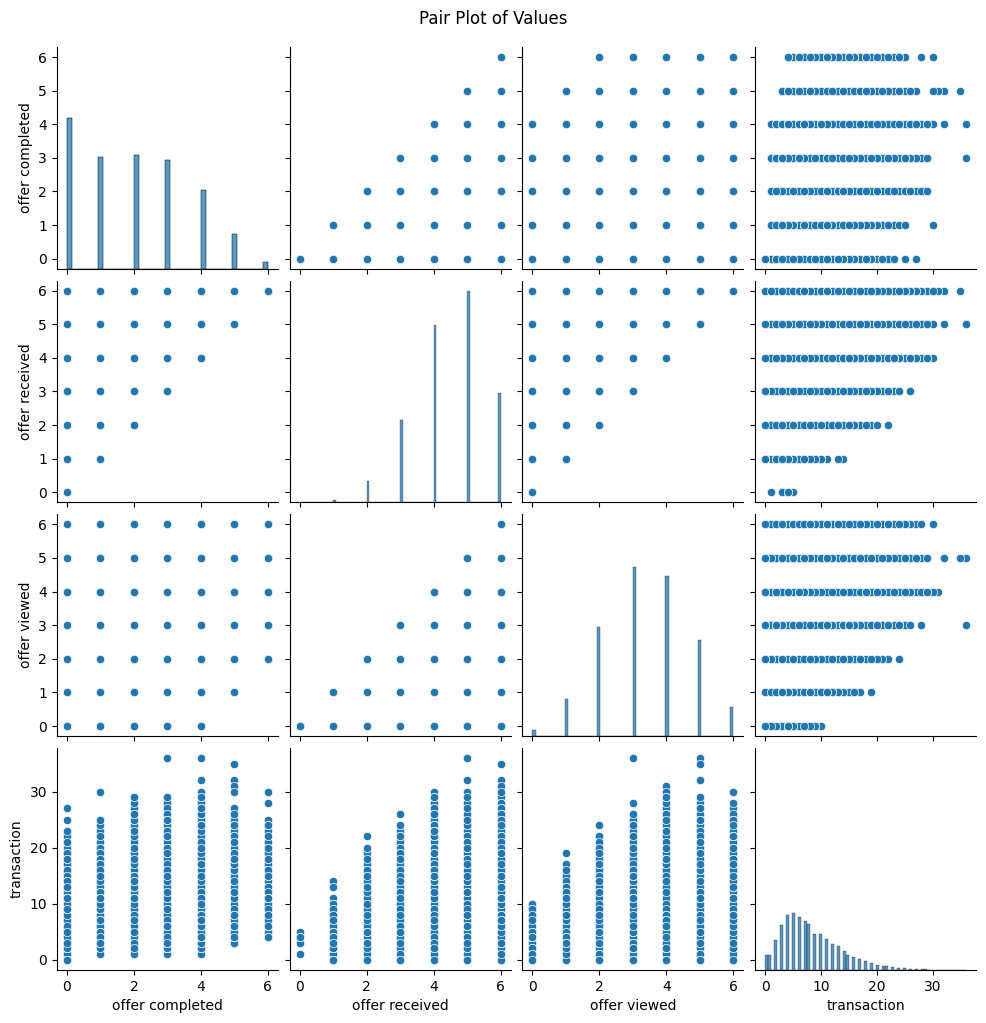

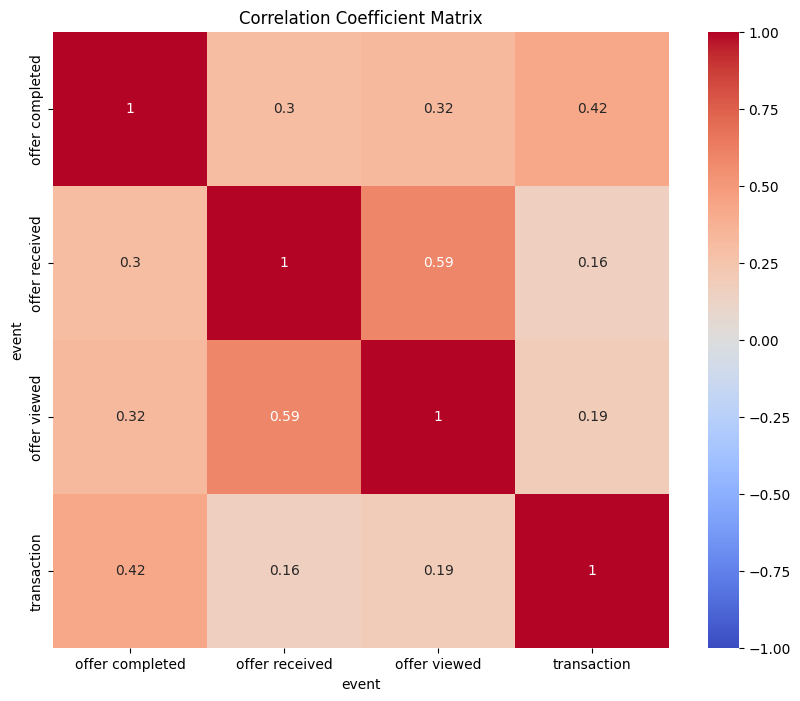

In [28]:
explore_quantitive_variables(pivoted_df, ["offer completed","offer received","offer viewed","transaction"])

## Preprocessing

### Portfolio

In [29]:
cleaned_portfolio_df = convert_list_to_string(portfolio, "channels").reset_index()
cleaned_portfolio_df["offer_group"] = 'offer_group_ ' + cleaned_portfolio_df['index'].astype(str)
cleaned_portfolio_df = cleaned_portfolio_df.drop(columns=["index"])
cleaned_portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id,concatenated_channels,offer_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,email+mobile+social,offer_group_ 0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,web+email+mobile,offer_group_ 2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,web+email+mobile,offer_group_ 3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,web+email,offer_group_ 4


### Profile

In [30]:
cleaned_profile = profile.fillna(0)
cleaned_profile["gender"] = cleaned_profile["gender"].replace(0,"NA")
cleaned_profile["became_member_on"] = pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d', errors='coerce')
cleaned_profile.head(9)

,gender,age,id,became_member_on,income
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NA,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,NA,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,0.0
7,NA,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,0.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0


### Transcript

In [31]:
cleaned_transcript_df = transcript
cleaned_transcript_df["offer_id"] = cleaned_transcript_df["value"].apply(lambda x: x.get("offer id"))
cleaned_transcript_df["amount"] = cleaned_transcript_df["value"].apply(lambda x: x.get("amount"))
cleaned_transcript_df.head()

,person,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [32]:
cleaned_transcript_df[~cleaned_transcript_df['amount'].isna()].head()

,person,event,value,time,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,None,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,None,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,None,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,None,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,None,18.97


## Feature Engineering

### Portfolio

In [33]:
## Does the columns offert_type + channels generates unique ids?
result = check_unique_combinations(cleaned_portfolio_df, ["concatenated_channels","offer_type"])
print("Are the combinations unique?", result)

Are the combinations unique? False


In [34]:
# What about finding a single field that represents the numeric values like an score?
score_portfolio_df = score_portfolio(cleaned_portfolio_df)
score_portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id,concatenated_channels,offer_group,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,score
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,email+mobile+social,offer_group_ 0,1.0,0.50,0.7,74.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1,1.0,0.50,0.5,70.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,web+email+mobile,offer_group_ 2,0.0,0.00,0.4,8.0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,web+email+mobile,offer_group_ 3,0.5,1.00,0.7,74.0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,web+email,offer_group_ 4,0.5,0.25,1.0,50.0


In [35]:
## Does the columns offert_type + channels generates + score generate unique ids?
fields = ["concatenated_channels","offer_type","score"]
result = check_unique_combinations(score_portfolio_df, fields)
print("Are the combinations unique?", result)

Are the combinations unique? False


In [36]:
# Which Id is duped?
duplicated_df = find_duplicate_ids(score_portfolio_df, fields)
duplicated_df.head()

,reward,channels,difficulty,duration,offer_type,id,concatenated_channels,offer_group,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,score
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1,1.0,0.5,0.5,70.0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,web+email+mobile+social,offer_group_ 8,0.5,1.0,0.5,70.0


Text(0.5, 1.0, 'Bar Plot of Score by Channels and Offer Type')

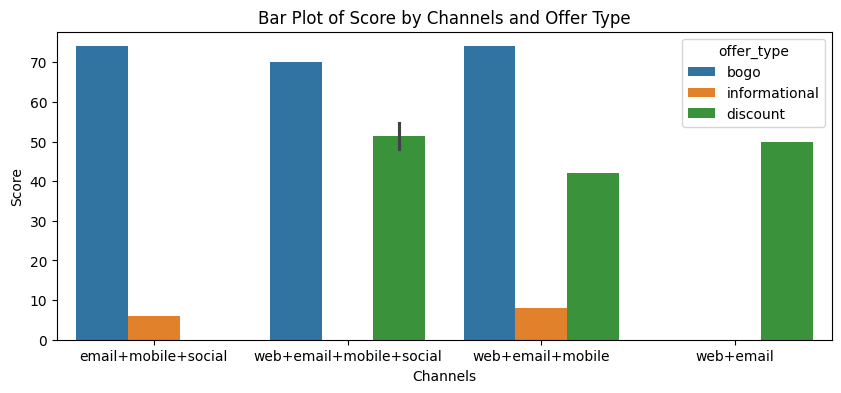

In [37]:
# Create the bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='concatenated_channels', y='score', hue='offer_type', data=score_portfolio_df)

# Add labels and title
plt.xlabel('Channels')
plt.ylabel('Score')
plt.title('Bar Plot of Score by Channels and Offer Type')

In [38]:
scale_score_portfolio_df = max_scaling(score_portfolio_df,"score")
scale_score_portfolio_df[["max_scaling_reward","min_scaling_difficulty","max_scaling_duration","max_scaling_score"]].head()

,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,max_scaling_score
0,1.0,0.50,0.7,1.000000
1,1.0,0.50,0.5,0.945946
2,0.0,0.00,0.4,0.108108
3,0.5,1.00,0.7,1.000000
4,0.5,0.25,1.0,0.675676


In [39]:
scale_score_portfolio_df[["max_scaling_reward","min_scaling_difficulty","max_scaling_duration","max_scaling_score"]].describe()

,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,max_scaling_score
count,10.000000,10.000000,10.00000,10.000000
mean,0.420000,0.496429,0.65000,0.671042
std,0.358391,0.350918,0.23214,0.341266
min,0.000000,0.000000,0.30000,0.081081
25%,0.200000,0.312500,0.50000,0.587838
50%,0.400000,0.500000,0.70000,0.706564
75%,0.500000,0.660714,0.70000,0.945946
max,1.000000,1.000000,1.00000,1.000000


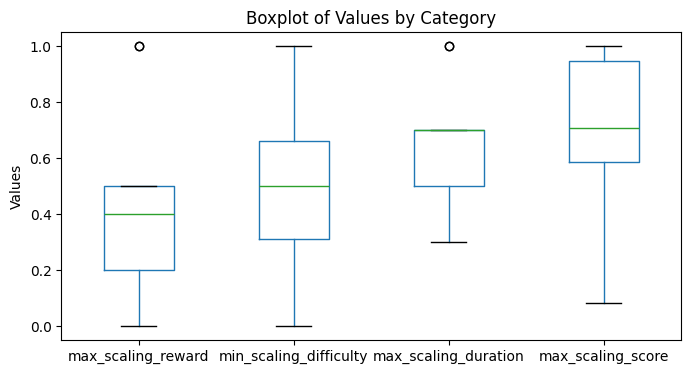

In [40]:
# Create a box plot
plt.figure(figsize=(8, 4))
score_portfolio_df.boxplot(column=["max_scaling_reward","min_scaling_difficulty","max_scaling_duration","max_scaling_score"], grid=False)

plt.title('Boxplot of Values by Category')
plt.suptitle('')  # Suppress the default title
plt.ylabel('Values')
plt.show()

In [41]:
final_portfolio_df = score_portfolio_df
final_portfolio_df = final_portfolio_df.rename(columns={'id': 'portfolio_id'})
final_portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,portfolio_id,concatenated_channels,offer_group,max_scaling_reward,min_scaling_difficulty,max_scaling_duration,score,max_scaling_score
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,email+mobile+social,offer_group_ 0,1.0,0.50,0.7,74.0,1.000000
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,web+email+mobile+social,offer_group_ 1,1.0,0.50,0.5,70.0,0.945946
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,web+email+mobile,offer_group_ 2,0.0,0.00,0.4,8.0,0.108108
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,web+email+mobile,offer_group_ 3,0.5,1.00,0.7,74.0,1.000000
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,web+email,offer_group_ 4,0.5,0.25,1.0,50.0,0.675676


### Profile

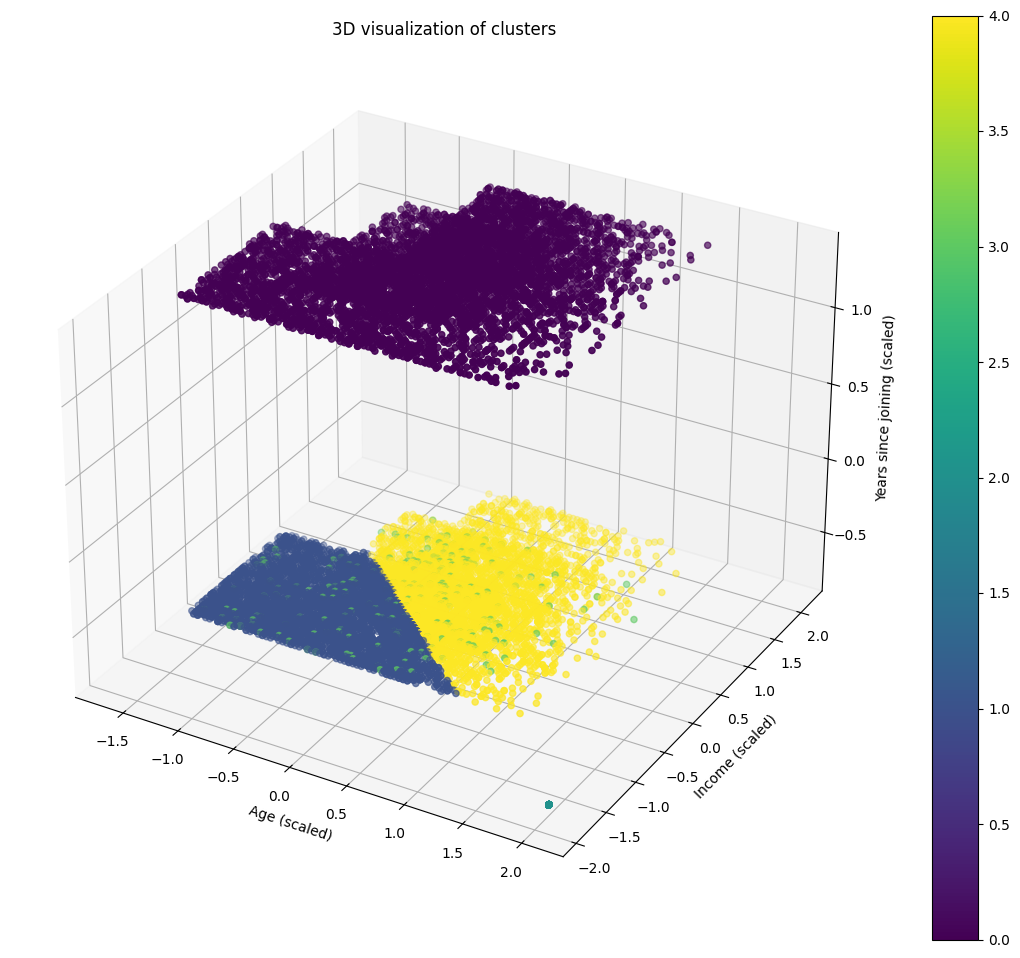

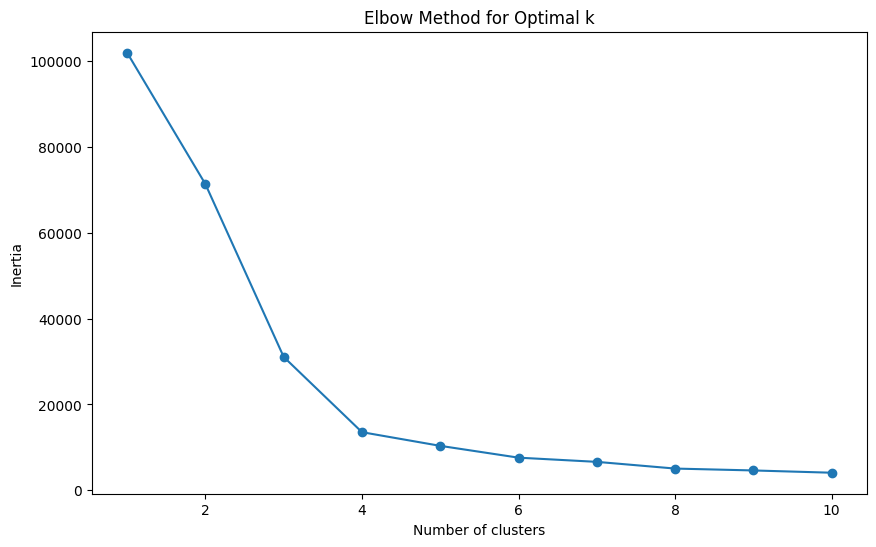

,gender,age,id,became_member_on,income,customer_type
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0
4,NA,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,2


In [42]:
clasify_profile_df = generate_profile_kmeans_clusters(cleaned_profile,5)
clasify_profile_df.head()

In [43]:
final_profile_df = clasify_profile_df
final_profile_df['years_since_joining'] = (pd.Timestamp('11/28/2024') - pd.to_datetime(final_profile_df['became_member_on'])).dt.days/365.25
final_profile_df = final_profile_df.rename(columns={'id': 'profile_id'})
final_profile_df.head()

,gender,age,profile_id,became_member_on,income,customer_type,years_since_joining
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,2,7.791923
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,7.373032
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,2,6.381930
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,7.556468
4,NA,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,2,7.318275


In [44]:
profile_result_df = final_profile_df.groupby(['customer_type', 'gender']).agg(
    age_min=('age', 'min'),
    age_max=('age', 'max'),
    income_min=('income', 'min'),
    income_max=('income', 'max'),
    years_min=('years_since_joining', 'min'),
    years_max=('years_since_joining', 'max'),
).reset_index()

profile_result_df.head(5)

,customer_type,gender,age_min,age_max,income_min,income_max,years_min,years_max
0,0,F,18,101,30000.0,120000.0,6.343600,11.331964
1,1,M,18,82,30000.0,77000.0,6.343600,11.331964
2,2,NA,118,118,0.0,0.0,6.343600,11.323751
3,3,O,20,100,30000.0,100000.0,6.365503,11.192334
4,4,M,36,100,30000.0,120000.0,6.343600,11.334702


### Transcript

In [45]:
transcript_renamed_df = cleaned_transcript_df.rename(columns={'offer_id': 'portfolio_id','person':'profile_id'})
final_transcript_df = pd.merge(transcript_renamed_df ,final_portfolio_df, on="portfolio_id", how="left")
final_transcript_df = pd.merge(final_transcript_df,final_profile_df, on="profile_id", how="inner")
final_transcript_df.head()

,profile_id,event,value,time,portfolio_id,amount,reward,channels,difficulty,duration,...,min_scaling_difficulty,max_scaling_duration,score,max_scaling_score,gender,age,became_member_on,income,customer_type,years_since_joining
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,...,1.00,0.7,74.0,1.000000,F,75,2017-05-09,100000.0,0,7.556468
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,"[web, email]",20.0,10.0,...,0.25,1.0,50.0,0.675676,NA,118,2017-08-04,0.0,2,7.318275
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, email, mobile]",10.0,7.0,...,0.50,0.7,42.0,0.567568,M,68,2018-04-26,70000.0,4,6.592745
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,...,0.50,1.0,48.0,0.648649,NA,118,2017-09-25,0.0,2,7.175907
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,...,0.50,0.5,70.0,0.945946,NA,118,2017-10-02,0.0,2,7.156742


### Features

In [46]:
features_df = final_transcript_df[["profile_id","customer_type","event","offer_group","time","amount","score"]].fillna(0)
features_df["label"] = np.where(features_df['offer_group'] == 0, features_df['event'] , features_df['offer_group'].astype(str))
features_df["label"] = np.where(features_df['label'] == 'transaction', 'amount' , features_df['label'])
features_df["value"] = np.where(features_df['event'] == 'transaction', features_df['amount'] , features_df['score'])
features_df["count"] = 1
features_df.head()

,profile_id,customer_type,event,offer_group,time,amount,score,label,value,count
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer received,offer_group_ 3,0,0.0,74.0,offer_group_ 3,74.0,1
1,a03223e636434f42ac4c3df47e8bac43,2,offer received,offer_group_ 4,0,0.0,50.0,offer_group_ 4,50.0,1
2,e2127556f4f64592b11af22de27a7932,4,offer received,offer_group_ 9,0,0.0,42.0,offer_group_ 9,42.0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,offer received,offer_group_ 6,0,0.0,48.0,offer_group_ 6,48.0,1
4,68617ca6246f4fbc85e91a2a49552598,2,offer received,offer_group_ 1,0,0.0,70.0,offer_group_ 1,70.0,1


In [47]:
pivoted_offer_group_df = (
    pd.pivot_table(
        features_df[features_df["event"]!="offer completed"],
        values='value',
        index=['profile_id','customer_type'],
        columns='label',
        aggfunc='sum',
        fill_value=0
    ).reset_index()
)
pivoted_offer_group_df.head()

label,profile_id,customer_type,amount,offer_group_ 0,offer_group_ 1,offer_group_ 2,offer_group_ 3,offer_group_ 4,offer_group_ 5,offer_group_ 6,offer_group_ 7,offer_group_ 8,offer_group_ 9
0,0009655768c64bdeb2e877511632db8f,1,127.60,0.0,0.0,16.0,0.0,0.0,0.000000,96.0,12.0,140.0,42.0
1,00116118485d4dfda04fdbaba9a87b5c,2,4.09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,280.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,79.46,0.0,0.0,16.0,148.0,100.0,109.142857,0.0,12.0,0.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,0,196.86,74.0,140.0,0.0,0.0,0.0,0.000000,144.0,12.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0,154.05,0.0,0.0,0.0,148.0,0.0,109.142857,0.0,12.0,140.0,0.0


In [48]:
events_df = (
    pd.pivot_table(
        features_df,
        values='count',
        index=['profile_id'],
        columns='event',
        aggfunc='sum',
        fill_value=0
    ).reset_index()
)
events_df.head()

event,profile_id,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3,5,4,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12


In [49]:
sum_time_df = features_df[features_df["event"]=="transaction"].groupby("profile_id")["time"].sum().reset_index()
sum_time_df.head()

,profile_id,time
0,0009655768c64bdeb2e877511632db8f,4344
1,00116118485d4dfda04fdbaba9a87b5c,1224
2,0011e0d4e6b944f998e987f904e8c1e5,2256
3,0020c2b971eb4e9188eac86d93036a77,2790
4,0020ccbbb6d84e358d3414a3ff76cffd,4500


In [50]:
final_features_df = pd.merge(pivoted_offer_group_df,events_df,on="profile_id",how="left")
final_features_df = pd.merge(final_features_df,sum_time_df,on="profile_id",how="left").fillna(0)
final_features_df.head()

,profile_id,customer_type,amount,offer_group_ 0,offer_group_ 1,offer_group_ 2,offer_group_ 3,offer_group_ 4,offer_group_ 5,offer_group_ 6,offer_group_ 7,offer_group_ 8,offer_group_ 9,offer completed,offer received,offer viewed,transaction,time
0,0009655768c64bdeb2e877511632db8f,1,127.60,0.0,0.0,16.0,0.0,0.0,0.000000,96.0,12.0,140.0,42.0,3,5,4,8,4344.0
1,00116118485d4dfda04fdbaba9a87b5c,2,4.09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,280.0,0.0,0,2,2,3,1224.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,79.46,0.0,0.0,16.0,148.0,100.0,109.142857,0.0,12.0,0.0,0.0,3,5,5,5,2256.0
3,0020c2b971eb4e9188eac86d93036a77,0,196.86,74.0,140.0,0.0,0.0,0.0,0.000000,144.0,12.0,0.0,0.0,3,5,3,8,2790.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0,154.05,0.0,0.0,0.0,148.0,0.0,109.142857,0.0,12.0,140.0,0.0,3,4,4,12,4500.0


In [51]:
columns = list(set(final_features_df.columns.tolist()) - set(["profile_id","customer_type"]))
print(columns)

['transaction', 'time', 'offer_group_ 2', 'offer_group_ 7', 'offer_group_ 8', 'offer_group_ 3', 'offer_group_ 9', 'offer_group_ 6', 'offer_group_ 4', 'offer completed', 'offer_group_ 5', 'offer_group_ 1', 'offer viewed', 'offer received', 'amount', 'offer_group_ 0']


        transaction          time  offer_group_ 2  offer_group_ 7  \
count  17000.000000  17000.000000    17000.000000    17000.000000   
mean       8.173706   3118.958118        5.534588        5.048824   
std        5.116250   1994.622142        8.442264        7.392612   
min        0.000000      0.000000        0.000000        0.000000   
25%        4.000000   1638.000000        0.000000        0.000000   
50%        7.000000   2724.000000        0.000000        0.000000   
75%       11.000000   4248.000000        8.000000       12.000000   
max       36.000000  15036.000000       64.000000       60.000000   

       offer_group_ 8  offer_group_ 3  offer_group_ 9  offer_group_ 6  \
count    17000.000000    17000.000000    17000.000000    17000.000000   
mean        61.085294       51.573647       29.029412       42.138353   
std         89.035420       78.572465       44.578932       60.662225   
min          0.000000        0.000000        0.000000        0.000000   
25%          

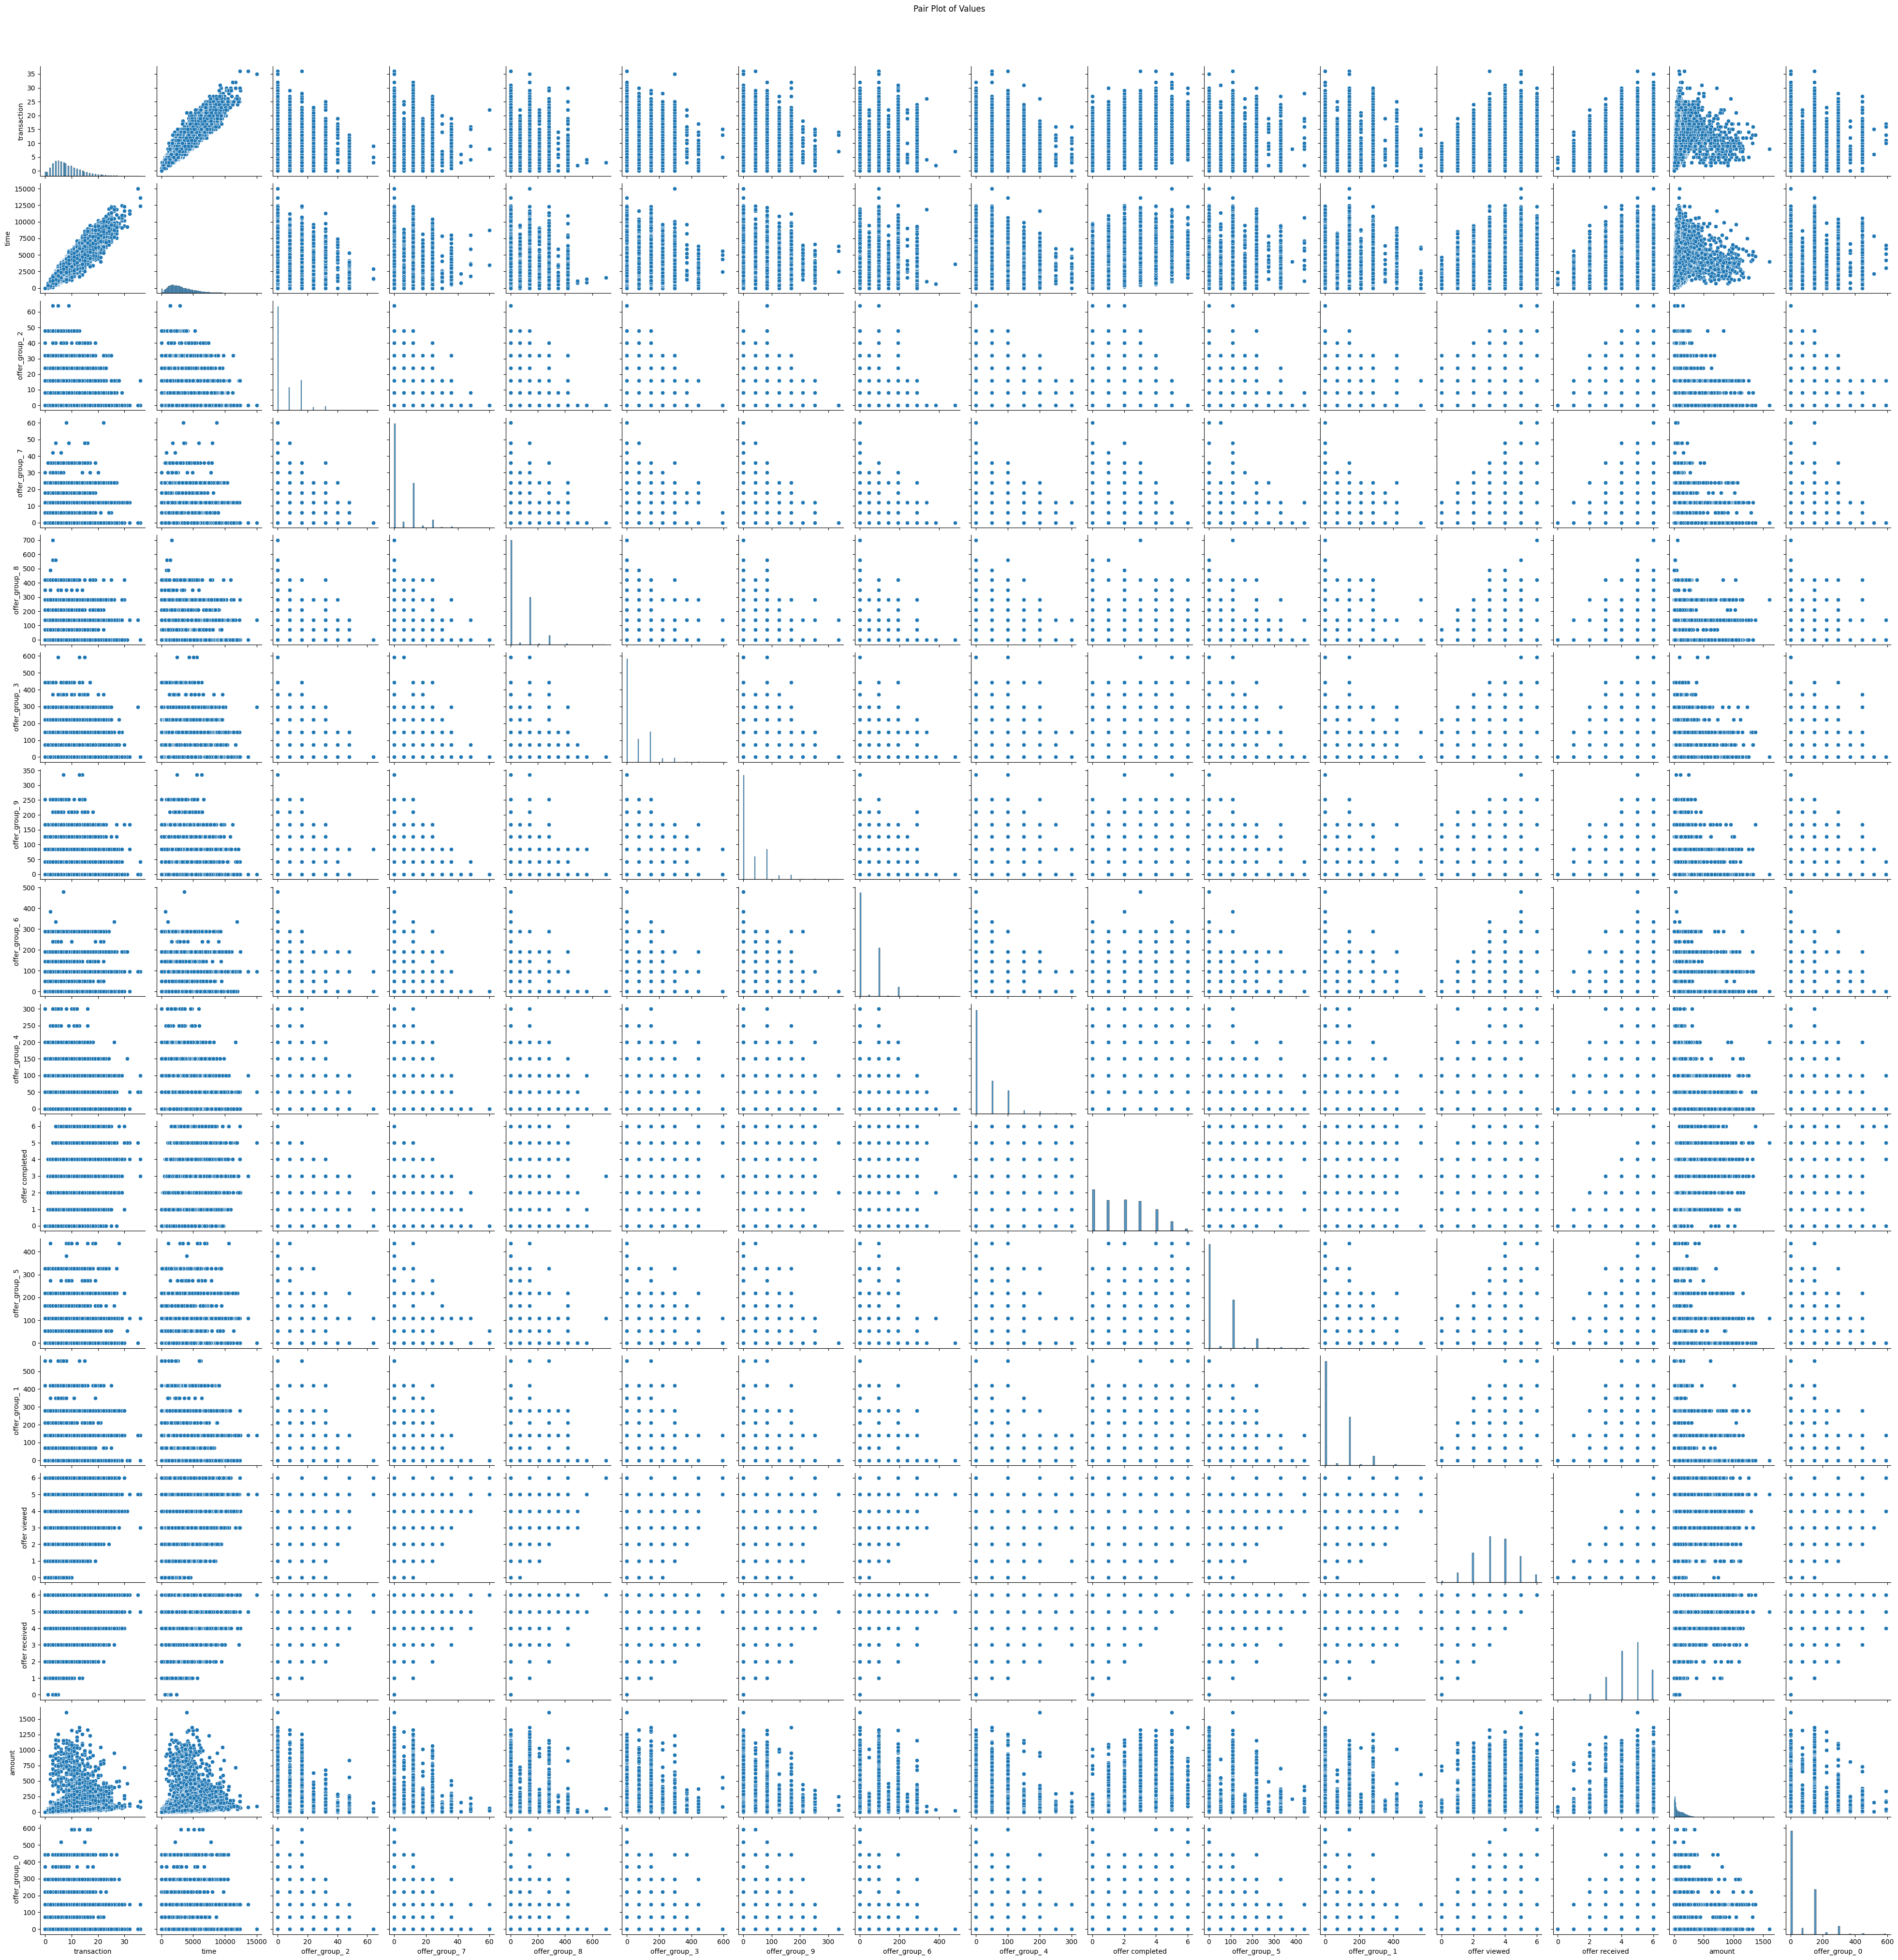

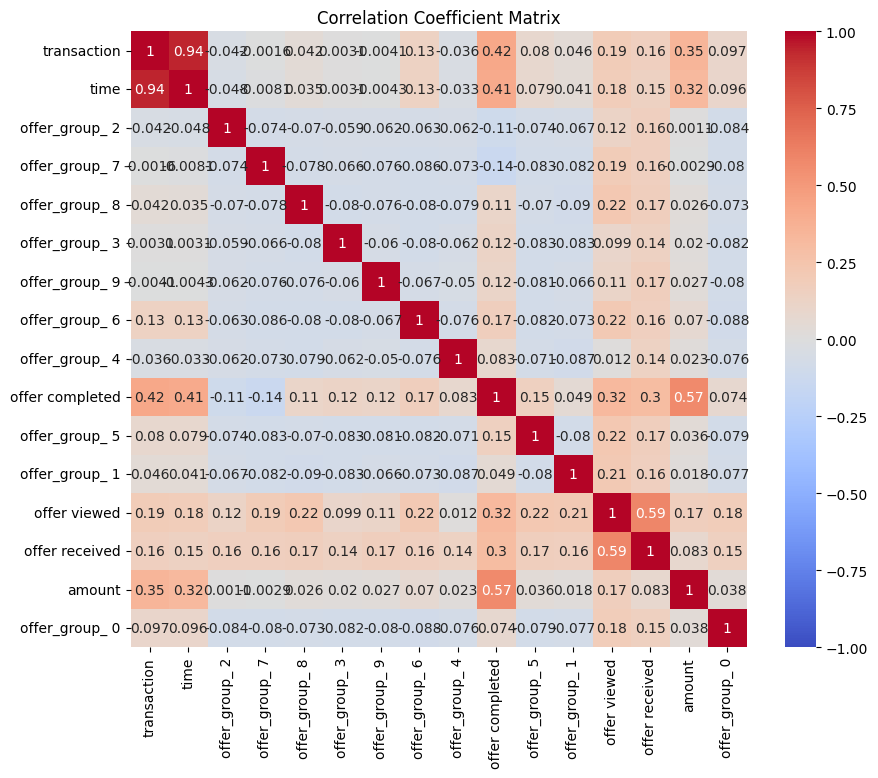

In [52]:
explore_quantitive_variables(final_features_df, columns)

## Inference

In [53]:
model_df= final_features_df
model_df["customer_type"] = "customer_type_" + model_df["customer_type"].astype("str")
model_df.head()

,profile_id,customer_type,amount,offer_group_ 0,offer_group_ 1,offer_group_ 2,offer_group_ 3,offer_group_ 4,offer_group_ 5,offer_group_ 6,offer_group_ 7,offer_group_ 8,offer_group_ 9,offer completed,offer received,offer viewed,transaction,time
0,0009655768c64bdeb2e877511632db8f,customer_type_1,127.60,0.0,0.0,16.0,0.0,0.0,0.000000,96.0,12.0,140.0,42.0,3,5,4,8,4344.0
1,00116118485d4dfda04fdbaba9a87b5c,customer_type_2,4.09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,280.0,0.0,0,2,2,3,1224.0
2,0011e0d4e6b944f998e987f904e8c1e5,customer_type_3,79.46,0.0,0.0,16.0,148.0,100.0,109.142857,0.0,12.0,0.0,0.0,3,5,5,5,2256.0
3,0020c2b971eb4e9188eac86d93036a77,customer_type_0,196.86,74.0,140.0,0.0,0.0,0.0,0.000000,144.0,12.0,0.0,0.0,3,5,3,8,2790.0
4,0020ccbbb6d84e358d3414a3ff76cffd,customer_type_0,154.05,0.0,0.0,0.0,148.0,0.0,109.142857,0.0,12.0,140.0,0.0,3,4,4,12,4500.0


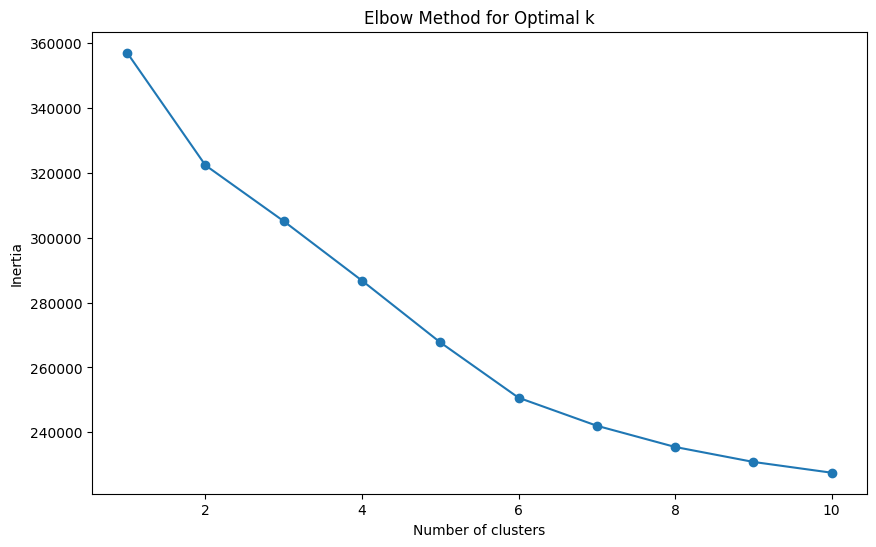

In [54]:
inference_df = generate_model_kmeans_clusters(model_df, 6)

## Analysis

In [55]:
aggregation_fields = list(set(inference_df.drop(columns=["profile_id"])) - set(["cluster","customer_type"]))
cluster_df = inference_df.groupby(["cluster","customer_type"])[aggregation_fields].sum().reset_index()
cluster_df["cluster"] = "cluster_" + cluster_df["cluster"].astype("str")
print(f"Number of rows: {len(cluster_df)}")
cluster_df.head(9)

Number of rows: 9


,cluster,customer_type,transaction,time,offer_group_ 2,offer_group_ 7,offer_group_ 8,offer_group_ 3,offer_group_ 9,offer_group_ 6,offer_group_ 4,offer completed,offer_group_ 5,offer_group_ 1,offer viewed,offer received,amount,offer_group_ 0
0,cluster_0,customer_type_0,21153,8073870.0,7264.0,7194.0,115850.0,94646.0,50778.0,94704.0,45800.0,6067,104067.714286,113960.0,6583,7893,390142.99,133348.0
1,cluster_0,customer_type_1,15353,5910174.0,3832.0,4032.0,67410.0,51578.0,29316.0,62976.0,23050.0,3177,63357.428571,68460.0,3867,4671,149800.98,82658.0
2,cluster_0,customer_type_2,462,176244.0,120.0,48.0,3010.0,814.0,882.0,2592.0,600.0,66,1582.571429,1120.0,108,129,1513.49,2072.0
3,cluster_0,customer_type_4,7185,2745840.0,2096.0,2028.0,39480.0,25308.0,17472.0,35040.0,13700.0,1872,31051.142857,35350.0,2113,2466,149241.87,42846.0
4,cluster_1,customer_type_2,14534,5583942.0,12816.0,10686.0,133420.0,122322.0,68796.0,86928.0,68900.0,1069,104777.142857,136710.0,7757,9647,38996.08,130388.0
5,cluster_2,customer_type_1,27792,10554654.0,18968.0,19260.0,201460.0,160950.0,88242.0,131376.0,102000.0,4081,154273.428571,210700.0,10534,15637,175827.53,208828.0
6,cluster_3,customer_type_4,22464,8576790.0,20816.0,17532.0,208250.0,183668.0,103572.0,134400.0,111500.0,7336,161695.142857,204820.0,11787,15355,370020.48,205424.0
7,cluster_4,customer_type_0,28229,10733760.0,26848.0,23910.0,257460.0,224368.0,128016.0,159888.0,143350.0,9410,186907.142857,261240.0,14203,19563,473552.01,245088.0
8,cluster_5,customer_type_3,1781,667014.0,1328.0,1140.0,12110.0,13098.0,6426.0,8448.0,7650.0,501,9932.000000,10010.0,773,916,26356.54,13024.0


In [56]:
quintile_analysis_df = replace_with_quintile_labels(cluster_df)
quintile_analysis_df.head()

,cluster,customer_type,transaction,time,offer_group_ 2,offer_group_ 7,offer_group_ 8,offer_group_ 3,offer_group_ 9,offer_group_ 6,offer_group_ 4,offer completed,offer_group_ 5,offer_group_ 1,offer viewed,offer received,amount,offer_group_ 0
0,cluster_0,customer_type_0,B,B,C,C,C,C,C,B,C,B,C,C,C,C,A,B
1,cluster_0,customer_type_1,C,C,D,D,D,D,D,D,D,C,D,D,D,D,C,D
2,cluster_0,customer_type_2,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E
3,cluster_0,customer_type_4,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D
4,cluster_1,customer_type_2,D,D,B,B,B,B,B,C,B,D,B,B,B,B,D,C


In [57]:
offers_ranking_df = final_portfolio_df[["offer_group","score"]].sort_values(by="score",ascending=False)
offers_ranking_df["rank"] = range(1, len(offers_ranking_df) + 1)
offers_ranking_df.head(10)

,offer_group,score,rank
0,offer_group_ 0,74.000000,1
3,offer_group_ 3,74.000000,2
1,offer_group_ 1,70.000000,3
8,offer_group_ 8,70.000000,4
5,offer_group_ 5,54.571429,5
4,offer_group_ 4,50.000000,6
6,offer_group_ 6,48.000000,7
9,offer_group_ 9,42.000000,8
2,offer_group_ 2,8.000000,9
7,offer_group_ 7,6.000000,10


In [58]:
offers_list = offers_ranking_df['offer_group'].tolist()
print(offers_list)

['offer_group_ 0', 'offer_group_ 3', 'offer_group_ 1', 'offer_group_ 8', 'offer_group_ 5', 'offer_group_ 4', 'offer_group_ 6', 'offer_group_ 9', 'offer_group_ 2', 'offer_group_ 7']


In [59]:
variables = ["amount","time","transaction","offer received","offer received","offer completed"] + offers_list
sorted_list = ["cluster","customer_type"] + variables
final_df = quintile_analysis_df[sorted_list].copy()
final_df.loc[:,"category"] = final_df[variables].astype(str).agg(''.join, axis=1)
final_df.head(9)

,cluster,customer_type,amount,time,transaction,offer received,offer received,offer completed,offer_group_ 0,offer_group_ 3,offer_group_ 1,offer_group_ 8,offer_group_ 5,offer_group_ 4,offer_group_ 6,offer_group_ 9,offer_group_ 2,offer_group_ 7,category
0,cluster_0,customer_type_0,A,B,B,C,C,B,B,C,C,C,C,C,B,C,C,C,ABBCCCCBBCCCCCBCCC
1,cluster_0,customer_type_1,C,C,C,D,D,C,D,D,D,D,D,D,D,D,D,D,CCCDDDDCDDDDDDDDDD
2,cluster_0,customer_type_2,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,EEEEEEEEEEEEEEEEEE
3,cluster_0,customer_type_4,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D,D,DDDDDDDDDDDDDDDDDD
4,cluster_1,customer_type_2,D,D,D,B,B,D,C,B,B,B,B,B,C,B,B,B,DDDBBBBDCBBBBBCBBB
5,cluster_2,customer_type_1,B,A,A,A,A,B,A,B,A,B,B,B,B,B,B,A,BAAAAAABABABBBBBBA
6,cluster_3,customer_type_4,B,B,B,B,B,A,B,A,B,A,A,A,A,A,A,B,BBBBBBBABABAAAAAAB
7,cluster_4,customer_type_0,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,AAAAAAAAAAAAAAAAAA
8,cluster_5,customer_type_3,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,E,EEEEEEEEEEEEEEEEEE


In [60]:
final_df[["cluster","customer_type","category"]].sort_values(by="category",ascending=True).head(9)

,cluster,customer_type,category
7,cluster_4,customer_type_0,AAAAAAAAAAAAAAAAAA
0,cluster_0,customer_type_0,ABBCCCCBBCCCCCBCCC
5,cluster_2,customer_type_1,BAAAAAABABABBBBBBA
6,cluster_3,customer_type_4,BBBBBBBABABAAAAAAB
1,cluster_0,customer_type_1,CCCDDDDCDDDDDDDDDD
4,cluster_1,customer_type_2,DDDBBBBDCBBBBBCBBB
3,cluster_0,customer_type_4,DDDDDDDDDDDDDDDDDD
2,cluster_0,customer_type_2,EEEEEEEEEEEEEEEEEE
8,cluster_5,customer_type_3,EEEEEEEEEEEEEEEEEE


In [61]:
melt_final_df = final_df.drop(columns=["category"]).copy()
melt_final_df = (
    pd.melt(
        melt_final_df,
        id_vars=['cluster', 'customer_type'],
        value_vars=offers_list,
        var_name='offer',
        value_name='category')
)
print(f"Number of rows: {len(portfolio)}")
melt_final_df.head(10)

Number of rows: 10


,cluster,customer_type,offer,category
0,cluster_0,customer_type_0,offer_group_ 0,B
1,cluster_0,customer_type_1,offer_group_ 0,D
2,cluster_0,customer_type_2,offer_group_ 0,E
3,cluster_0,customer_type_4,offer_group_ 0,D
4,cluster_1,customer_type_2,offer_group_ 0,C
5,cluster_2,customer_type_1,offer_group_ 0,A
6,cluster_3,customer_type_4,offer_group_ 0,B
7,cluster_4,customer_type_0,offer_group_ 0,A
8,cluster_5,customer_type_3,offer_group_ 0,E
9,cluster_0,customer_type_0,offer_group_ 3,C


In [62]:
profile_fileds = list(profile_result_df.columns)

required_fields = (
    [
        "offer",
        "concatenated_channels",
        "offer_type",
        "reward",
        "difficulty",
        "duration"
    ] +
    profile_fileds +
    ["category"]
)

In [63]:
rename_profile_result_df = profile_result_df.copy()
rename_profile_result_df["customer_type"] = "customer_type_" + rename_profile_result_df["customer_type"].astype("str")

rename_portfolio_result_df = cleaned_portfolio_df.copy()
rename_portfolio_result_df = rename_portfolio_result_df.rename(columns={"offer_group":"offer"})

analysis_df = melt_final_df.copy()
analysis_df = pd.merge(analysis_df,rename_profile_result_df, on="customer_type",how="inner")
analysis_df = pd.merge(analysis_df,rename_portfolio_result_df, on="offer",how="inner")
analysis_df = analysis_df[required_fields]
analysis_df[required_fields].head()

,offer,concatenated_channels,offer_type,reward,difficulty,duration,customer_type,gender,age_min,age_max,income_min,income_max,years_min,years_max,category
0,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_0,F,18,101,30000.0,120000.0,6.3436,11.331964,B
1,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_1,M,18,82,30000.0,77000.0,6.3436,11.331964,D
2,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_2,NA,118,118,0.0,0.0,6.3436,11.323751,E
3,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_4,M,36,100,30000.0,120000.0,6.3436,11.334702,D
4,offer_group_ 0,email+mobile+social,bogo,10,10,7,customer_type_2,NA,118,118,0.0,0.0,6.3436,11.323751,C


## Conclusions

Premise:

"Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type."

In [64]:
# Best Performance
conclusion_df = analysis_df.copy()
conclusion_df = conclusion_df.sort_values(by='category', ascending=False).drop_duplicates(subset=['offer', 'customer_type'], keep='first').drop(columns=["offer","customer_type"])
conclusion_df.head()

,concatenated_channels,offer_type,reward,difficulty,duration,gender,age_min,age_max,income_min,income_max,years_min,years_max,category
43,web+email+mobile+social,discount,3,7,7,F,18,101,30000.0,120000.0,6.3436,11.331964,A
51,web+email,discount,5,20,10,M,36,100,30000.0,120000.0,6.3436,11.334702,A
25,web+email+mobile+social,bogo,10,10,5,F,18,101,30000.0,120000.0,6.3436,11.331964,A
23,web+email+mobile+social,bogo,10,10,5,M,18,82,30000.0,77000.0,6.3436,11.331964,A
69,web+email+mobile,discount,2,10,7,M,36,100,30000.0,120000.0,6.3436,11.334702,A


In [65]:
# Other genders
conclusion_df = analysis_df.copy()
conclusion_df = conclusion_df[~conclusion_df["gender"].isin(["F","M"])].sort_values(by='category', ascending=False).drop_duplicates(subset=['offer', 'customer_type'], keep='first').drop(columns=["offer","customer_type"])
conclusion_df.head()

,concatenated_channels,offer_type,reward,difficulty,duration,gender,age_min,age_max,income_min,income_max,years_min,years_max,category
85,email+mobile+social,informational,0,0,3,NA,118,118,0.0,0.0,6.3436,11.323751,B
49,web+email,discount,5,20,10,NA,118,118,0.0,0.0,6.3436,11.323751,B
13,web+email+mobile,bogo,5,5,7,NA,118,118,0.0,0.0,6.3436,11.323751,B
76,web+email+mobile,informational,0,0,4,NA,118,118,0.0,0.0,6.3436,11.323751,B
22,web+email+mobile+social,bogo,10,10,5,NA,118,118,0.0,0.0,6.3436,11.323751,B
